In [1]:
import sys; sys.path.append('..')
import random
import pyzx as zx
from pyzx.linalg import *
from fractions import Fraction
%config InlineBackend.figure_format = 'svg'

Available backends: simple, igraph


In [48]:
def t_count(g): return len([v for v in g.vertices() if g.get_angle(v).denominator == 4])

In [73]:
random.seed(200)
circ = zx.examples.cliffordT(3, 50, p_t=0.3)
t_count(circ)

18

In [57]:
def gadgetize(g, qubits):
    newv = g.vindex
    for v in list(g.vertices()):
        va = g.get_angle(v)
        vt = g.get_type(v)
        vq = g.get_vdata(v,'q')
        vr = g.get_vdata(v,'r')
        if va.denominator > 2:
            g.set_angle(v, 0)
            
            g.add_vertex()
            g.set_type(newv, 2)
            g.set_vdata(newv, 'q', qubits)
            g.set_vdata(newv, 'r', vr)
            newv+=1
            
            g.add_vertex()
            g.set_type(newv, vt)
            g.set_angle(newv, va)
            g.set_vdata(newv, 'q', qubits+1)
            g.set_vdata(newv, 'r', vr)
            newv += 1
            
            g.add_edges([(v,newv-2),(newv-2,newv-1)])

In [13]:
zx.spider_simp(circ)
zx.drawing.pack_circuit_ranks(circ)
gadgetize(circ)

spider_simp

finished in 1 iterations


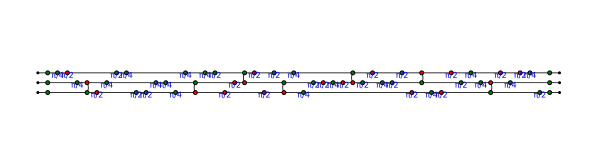

In [74]:
zx.draw(circ)

In [151]:
random.seed(1337)
circ = zx.examples.cliffordT(3, 1000, p_t=0.02)
print('t-count:', t_count(circ))
zx.clifford_simp(circ)
zx.drawing.pack_circuit_ranks(circ)
print('t-count:', t_count(circ))

t-count: 11
spider_simp
260. 185. 113. 64. 37. 13. 7. 2. 1. 
finished in 10 iterations
pivot_simp
75. 36. 11. 2. 
finished in 5 iterations
lcomp_simp
168. 60. 46. 33. 25. 15. 10. 8. 4. 4. 3. 3. 3. 2. 3. 2. 2. 2. 1. 2. 2. 1. 
finished in 23 iterations
pivot_simp
1. 
finished in 2 iterations
t-count: 7


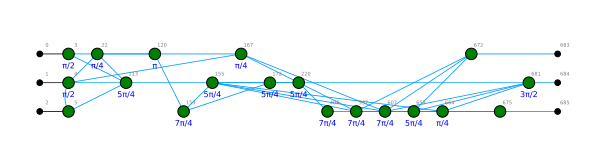

In [132]:
zx.draw(circ, labels=True)

In [7]:
def after(g, vs):
    rank = max(g.get_vdata(v, 'r') for v in vs)
    return [w for w in g.vertices() if g.get_vdata(w, 'r') > rank and any(g.is_connected(v, w) for v in vs)]
def bi_adj(g, vs, ws):
    return Mat2([[1 if g.is_connected(v,w) else 0 for v in vs] for w in ws])
def fwd_adj(g, vs):
    return bi_adj(g, vs, after(g,vs))
def cut_at(g, depth):
    return ([v for v in g.vertices() if g.get_vdata(v, 'r') <= depth],
            [v for v in g.vertices() if g.get_vdata(v, 'r') > depth])

In [395]:
def cut_edges(g, left, right):
    m = bi_adj(g, left, right)
    max_r = max(g.get_vdata(v, 'r') for v in left)
    for v in g.vertices():
        r = g.get_vdata(v,'r')
        if (r > max_r):
            g.set_vdata(v, 'r', r+2)
    x,y = m.factor()

    for v1 in left:
        for v2 in right:
            if (g.is_connected(v1,v2)):
                g.remove_edge(g.edge(v1,v2))
    
    vi = g.num_vertices()
    cut_rank = y.rows()
    g.add_vertices(2*cut_rank)
    
    for i in range(cut_rank):
        v = vi+i
        g.set_type(v,1)
        g.set_vdata(v, 'q', i)
        g.set_vdata(v, 'r', max_r+1)
    for i in range(cut_rank):
        v = vi+cut_rank+i
        g.set_type(v,1)
        g.set_vdata(v, 'q', i)
        g.set_vdata(v, 'r', max_r+2)
        g.add_edge((vi+i,v))
        g.set_edge_type(g.edge(vi+i,v), 2)
    for i in range(y.rows()):
        for j in range(y.cols()):
            if (y.data[i][j]):
                g.add_edge((left[j], vi + i))
                g.set_edge_type(g.edge(left[j], vi + i), 2)
    for i in range(x.rows()):
        for j in range(x.cols()):
            if (x.data[i][j]):
                g.add_edge((vi + cut_rank + j, right[i]))
                g.set_edge_type(g.edge(vi + cut_rank + j, right[i]), 2)
    

def cut_circuit(g, rank, qubits):
    cut = cut_at(g, rank)
    m = bi_adj(g, cut[0], cut[1])
    x,y = m.factor()

    for v in g.vertices():
        r = g.get_vdata(v,'r')
        if (r > rank):
            g.set_vdata(v, 'r', r+2)
    for v1 in cut[0]:
        for v2 in cut[1]:
            if (g.is_connected(v1,v2)):
                g.remove_edges([g.edge(v1,v2)])
    vi = g.num_vertices()
    g.add_vertices(2*qubits)
    for i in range(qubits):
        v = vi+i
        g.set_type(v,1)
        g.set_vdata(v, 'q', i)
        g.set_vdata(v, 'r', rank+1)
    for i in range(qubits):
        v = vi+qubits+i
        g.set_type(v,1)
        g.set_vdata(v, 'q', i)
        g.set_vdata(v, 'r', rank+2)
        g.add_edge((vi+i,v))
        g.set_edge_type(g.edge(vi+i,v), 2)
    for i in range(y.rows()):
        for j in range(y.cols()):
            if (y.data[i][j]):
                g.add_edge((cut[0][j], vi + i))
                g.set_edge_type(g.edge(cut[0][j], vi + i), 2)
    for i in range(x.rows()):
        for j in range(x.cols()):
            if (x.data[i][j]):
                g.add_edge((vi + qubits + j, cut[1][i]))
                g.set_edge_type(g.edge(vi + qubits + j, cut[1][i]), 2)
def cut_at_vertex(g, v, qubits):
    cut_circuit(g, g.get_vdata(v,'r'), qubits)
    g.set_vdata(v,'q',qubits+1)

In [402]:
qubits = 4

random.seed(240)
circ = zx.examples.cliffordT(qubits, 40, p_t=0.1)
print('t-count:', t_count(circ))
zx.clifford_simp(circ)
zx.drawing.pack_circuit_ranks(circ)
print('t-count:', t_count(circ))

g = circ.copy()
r = 0
for i in range(g.num_vertices()):#g.num_vertices()-2*qubits+1):
    g.set_vdata(i, 'r', i)

#g.set_vdata(6, 'q', 4)
#g.set_vdata(6, 'r', 4)
#g.set_vdata(7, 'q', 5)
#g.set_vdata(7, 'r', 4)
#cut_at_vertex(g, 8, qubits)
fix = []
for i in range(2*qubits,g.num_vertices()-2*qubits+1):
    cut_at_vertex(g, i, qubits)
#     fix.append(i)
#     r = g.get_vdata(i,'r')
#     if i % qubits == qubits-1:
#         cut_at_vertex(g, i, qubits)
#         for j,v in enumerate(fix):
#             g.set_vdata(v,'q',qubits+j)
#             g.set_vdata(v,'r',r)
#         fix = []

t-count: 6
spider_simp
12. 7. 5. 2. 1. 1. 
finished in 7 iterations
pivot_simp
4. 1. 
finished in 3 iterations
lcomp_simp
7. 1. 1. 1. 1. 
finished in 6 iterations
pivot_simp
1. 
finished in 2 iterations
t-count: 6


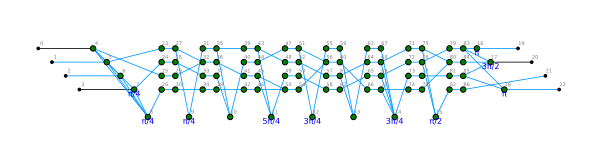

In [403]:
zx.draw(g,labels=True)

In [410]:
print(bi_adj(g, [35,36,37,38],[39,40,41,42]))

[ 1  0  0  0 ]
[ 0  0  0  0 ]
[ 0  1  0  0 ]
[ 0  0  0  1 ]


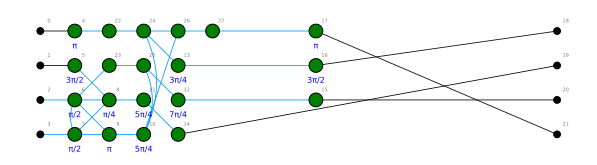

In [293]:
g1 = circ.copy()
cut_edges(g1, [4,5,6,7], [10,12,13,17])
g1.set_vdata(8,'q',2)
g1.set_vdata(8,'r',2)
g1.set_vdata(9,'q',3)
g1.set_vdata(9,'r',2)
g1.set_vdata(11,'q',2)
g1.set_vdata(11,'r',3)
g1.set_vdata(10,'q',3)
g1.set_vdata(10,'r',3)
cut_edges(g1, [10,11,24,25],[17])
g1.set_vdata(13,'q',1)
g1.set_vdata(13,'r',4)
g1.set_vdata(12,'q',2)
g1.set_vdata(12,'r',4)
g1.set_vdata(14,'q',3)
g1.set_vdata(14,'r',4)
g1.set_vdata(16,'q',1)
g1.set_vdata(16,'r',8)
g1.set_vdata(15,'q',2)
g1.set_vdata(15,'r',8)
g1.set_vdata(17,'q',0)
g1.set_vdata(17,'r',8)
zx.draw(g1,labels=True)

In [390]:
# DOESNT WORK
random.seed(1337)
circ = zx.examples.cliffordT(qubits, 400, p_t=0.1)

# WORKS
# random.seed(140)
# circ = zx.examples.cliffordT(qubits, 40, p_t=0.5)
print('t-count:', t_count(circ))
zx.clifford_simp(circ)
zx.drawing.pack_circuit_ranks(circ)
print('t-count:', t_count(circ))

t-count: 37
spider_simp
106. 70. 39. 23. 18. 10. 5. 1. 
finished in 9 iterations
pivot_simp
29. 14. 6. 1. 
finished in 5 iterations
lcomp_simp
72. 18. 12. 7. 8. 7. 2. 3. 2. 2. 1. 1. 1. 1. 1. 
finished in 16 iterations
pivot_simp
2. 
finished in 2 iterations
t-count: 25


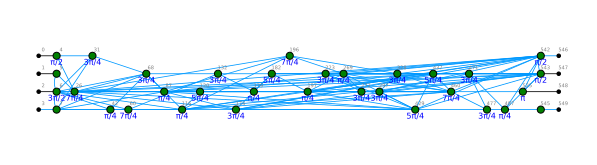

In [391]:
zx.draw(circ, labels=True)

In [378]:
after(g, [4,5,6,7])

[8, 9, 10, 12, 13, 17]

[ 1  0  1  0 ]
[ 0  0  1  0 ]
[ 1  0  0  0 ]
[ 1  0  0  0 ]
[ 1  1 ]
[ 0  1 ]
[ 1  0 ]
[ 1  0 ]
[ 1  0  0  0 ]
[ 0  0  1  0 ]


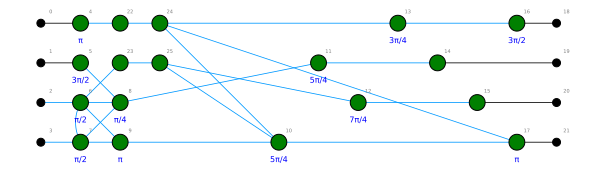

In [388]:
g = circ.copy()
m = bi_adj(g, [4,5,6,7], [10, 12, 13, 17])
print(m)
list(map(print,m.factor()))
cut_edges(g, [4,5,6,7], [10, 12, 13, 17])
g.set_vdata(8, 'q', 2)
g.set_vdata(8, 'r', 2)
g.set_vdata(9, 'q', 3)
g.set_vdata(9, 'r', 2)
zx.draw(g, labels=True)

terminated normally


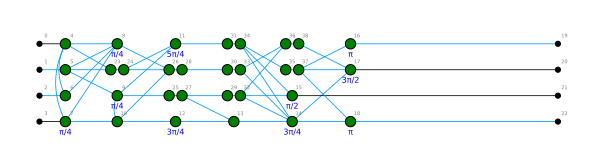

In [443]:
g = circ.copy()
qubits = 4
last_row = [4,5,6,7]

cut = False

while True:
    row1 = after(g, last_row)
    if len(row1) == 0:
        print('terminated normally')
        break
    
    row0 = []
    m = None
    while len(row1) != 0:
        v = row1.pop(0)
        m1 = bi_adj(g, last_row, row1)
        if m1.rank() + len(row0) + 1 > qubits:
            row1.insert(0,v)
            break
        else:
            row0.append(v)
            m = m1
    if m == None:
        if not cut:
            print('could not solve row ', last_row, ' trying cut at ', row1[0])
            cut = True
            cut_at_vertex(g, row1[0], qubits)
            continue
        else:
            print('no solution after cutting, giving up')
            break
        
    cut = False
    max_r = max(g.get_vdata(v, 'r') for v in last_row)
    extra = qubits - len(row0)
    
    if (len(row1) != 0):
        cut_edges(g, last_row, row1)
        taken = set(g.get_vdata(v,'q') for v in row0)
        free = [q for q in range(0,qubits) if q not in taken]
        for v in range(g.num_vertices()-extra,g.num_vertices()):
            q = free.pop()
            g.set_vdata(v-extra,'q',q)
            g.set_vdata(v-extra,'r',max_r+1.75)
            g.set_vdata(v,'q',q)
            g.set_vdata(v,'r',max_r+2.25)
            
    for i,v in enumerate(row0):
        if g.get_type(v) != 0:
            g.set_vdata(v,'r',max_r+2)
        #g.set_vdata(v,'q',extra+i)
        
    last_row = list(range(g.num_vertices()-extra,g.num_vertices())) + row0
    #out = (last_row, row0, row1)
        

zx.draw(g, labels=True)

In [436]:
g.get_vdata(24,'q')

1

In [416]:
after(g, [23,8,9,10])

[11, 24, 25, 26, 27]

In [415]:
bi_adj(g,[24,8,9,10],[25,26,27]).rank()

3

In [426]:
list(range(20-6,20,2))

[14, 16, 18]